In [1]:
import os
import numpy as np
import pandas as pd

Data 목록
- mACStatus
- mActiviy
- mAmbience
- mBle
- mGps
- mLight
- mScreenStatus
- mUsageStats
- mWifi
- wHr
- wLight
- wPedo


### (1) mActivity
- m_activity
  - 0: IN_VEHICLE
  - 1: ON_BICYCLE
  - 2: ON_FOOT
  - 3: STILL
  - 4: UNKNOWN
  - 5: TILTING
  - 7: WALKING
  - 8: RUNNING

In [ ]:
df1 = pd.read_parquet("ch2025_mActivity.parquet")
df1.info()
df1.head()

In [ ]:
print(df1.columns)

Index(['subject_id', 'timestamp', 'm_activity'], dtype='object')


In [ ]:
df1.isnull().sum()

,0
subject_id,0
timestamp,0
m_activity,0
activity_label,0


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.unicode_minus'] = False

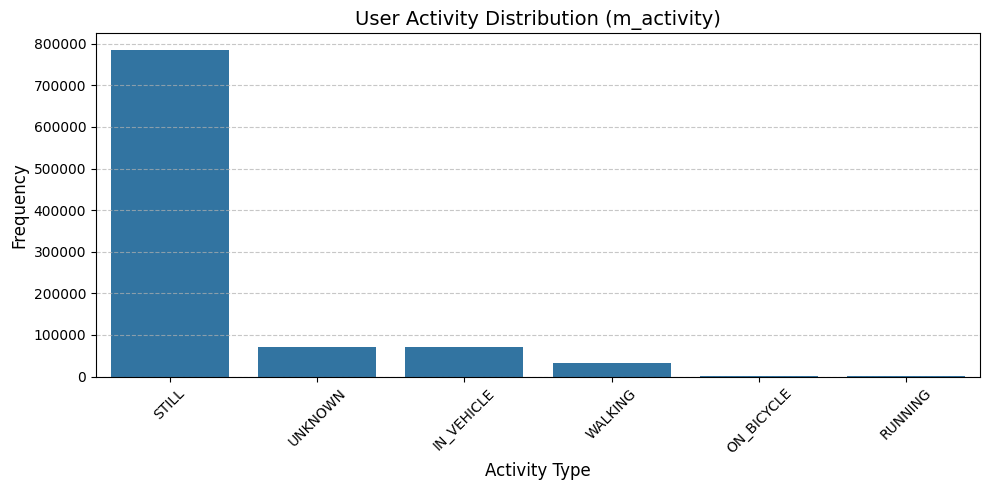

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 활동 코드
activity_labels = {
    0: "IN_VEHICLE",
    1: "ON_BICYCLE",
    2: "ON_FOOT",
    3: "STILL",
    4: "UNKNOWN",
    5: "TILTING",
    7: "WALKING",
    8: "RUNNING"
}

df1['activity_label'] = df1['m_activity'].map(activity_labels)

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(data=df1, x='activity_label', order=df1['activity_label'].value_counts().index)
plt.title("User Activity Distribution (m_activity)", fontsize=14)
plt.xlabel("Activity Type", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

전체 활동 중 STILL 상태가 가장 높은 비중을 차지하였음

이는 피험자가 상당 시간 동안 신체 활동 없이 정적인 상태에 있었음을 나타냄.

이러한 분포는 일상 생활에서의 일반적인 행동 양상을 반영하거나,
센서가 착용되지 않았던 구간의 영향을 받을 가능성도 존재한다.

따라서 STILL 상태는 모델링 과정에서 기준선(baseline)으로 설정할 수 있으며,
비정상적이거나 동적인 변화에 주목한 특성 기반 분석이 효과적일 것으로 판단됨.

In [ ]:
print(df1['m_activity'].value_counts().sort_index())

m_activity
0     70506
1      1056
3    785792
4     71502
7     31404
8       802
Name: count, dtype: int64


활동 코드 `2 (ON_FOOT)` 및 `5 (TILTING)`은 전체 데이터셋에서 한 차례도 관측되지 않았음.

이는 해당 활동이 실험 환경에서 발생하지 않았거나, 센서 감지 오류 또는 사전 전처리 과정에서 제거되었을 가능성.

(1) mACStatus 스마트폰 충전여부
- 0,1 이진분류

In [ ]:
df2 = pd.read_parquet("ch2025_mACStatus.parquet")
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939896 entries, 0 to 939895
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   subject_id  939896 non-null  object        
 1   timestamp   939896 non-null  datetime64[ns]
 2   m_charging  939896 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 21.5+ MB


,subject_id,timestamp,m_charging
0,id01,2024-06-26 12:03:00,0
1,id01,2024-06-26 12:04:00,0
2,id01,2024-06-26 12:05:00,0
3,id01,2024-06-26 12:06:00,0
4,id01,2024-06-26 12:07:00,0


In [ ]:
df2.isnull().sum()

,0
subject_id,0
timestamp,0
m_charging,0


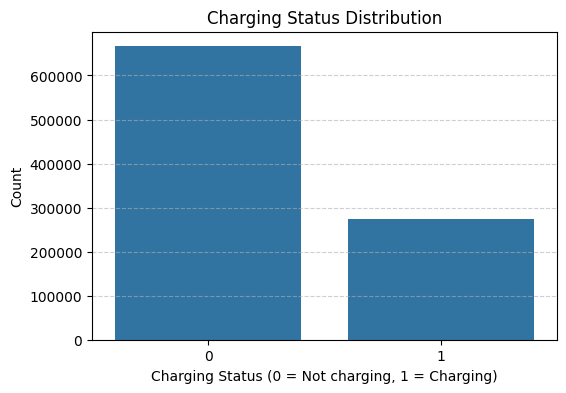

In [ ]:
# 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df2, x='m_charging')
plt.title("Charging Status Distribution")
plt.xlabel("Charging Status (0 = Not charging, 1 = Charging)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### 충전 상태(`m_charging`) 값 해석

데이터셋 공식 가이드에 따르면, `m_charging` 컬럼은 기기의 충전 여부를 나타낸다.  
- `0`: 충전 중이 아님  
- `1`: 충전 중

실제 데이터 분포에서도 대부분의 값이 `0`으로 나타나며, 이는 일상적인 사용 중 대부분의 시간이 비충전 상태임을 의미

반면, `1` 값은 특정 시간대에 집중되어 나타나는 경향이 있으며, 이는 야간 혹은 정해진 시간대에 충전이 이루어졌음을 나타냄.

이러한 충전 패턴은 사용자의 행동 특성이나 디바이스 관리 습관을 반영할 수 있으며, 시간 기반 특성으로 활용될 수 있다

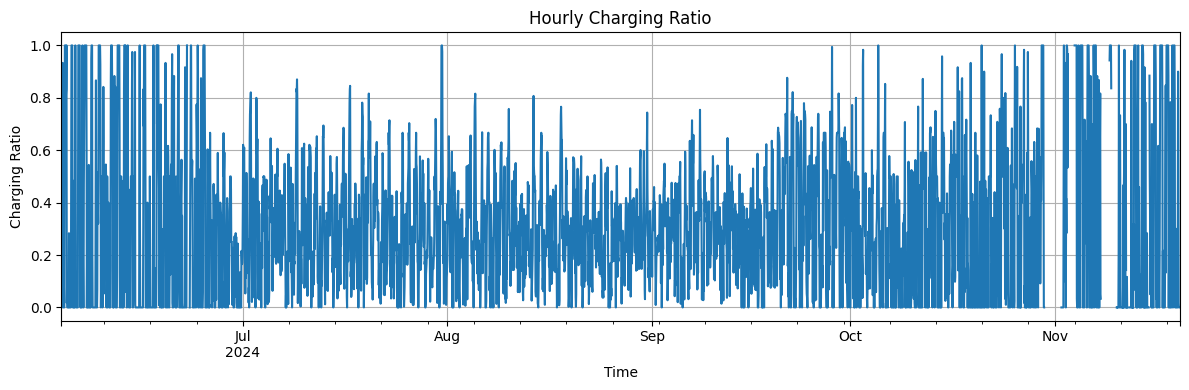

In [ ]:
df2['m_charging'].resample('1h').mean().plot(figsize=(12, 4))
plt.title("Hourly Charging Ratio")
plt.ylabel("Charging Ratio")
plt.xlabel("Time")
plt.grid()
plt.tight_layout()
plt.show()


충전 비율 그래프의 가로축은 2024년 6월부터 11월까지의 시간 흐름을 나타낸다.
이는 데이터가 시계열(timestamp 기반)로 구성되어 있고,

1시간 단위로 충전 여부를 평균 집계하여 시각화했기 때문이다. 실제로는 더 촘촘함.

다만, 시각화 시 너무 많은 x축 라벨이 겹치는 것을 방지하기 위해 matplotlib에서 자동으로 월(month) 단위로 요약하여 표시하고 있음


시간 단위로 `m_charging` 값을 집계한 결과, 대부분의 시간대에서는 평균값이 0.0에 가깝게 나타났다.  
이는 해당 시간 동안 기기가 충전되지 않았음을 의미하며, 충전은 특정 시간 구간에 집중적으로 발생하는 것으로 나타난다.  
충전 비율이 1.0에 가까운 구간은 해당 시간 동안 충전이 지속적으로 이루어졌음을 나타내며, 이는 야간 시간대나 휴식 시간 등에 해당할 가능성이 있다.

### (3) mAmbience

스마트폰이 2분마다 자동으로 주변 소리를 인식하고,
인식된 소리 환경 라벨 10개와 각각의 확률을 기록한 데이터

In [ ]:
df3 = pd.read_parquet("ch2025_mAmbience.parquet")
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476577 entries, 0 to 476576
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   subject_id  476577 non-null  object        
 1   timestamp   476577 non-null  datetime64[ns]
 2   m_ambience  476577 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 10.9+ MB


,subject_id,timestamp,m_ambience
0,id01,2024-06-26 13:00:10,"[[Music, 0.30902618], [Vehicle, 0.081680894], ..."
1,id01,2024-06-26 13:02:10,"[[Music, 0.62307084], [Vehicle, 0.021118319], ..."
2,id01,2024-06-26 13:04:10,"[[Horse, 0.25209898], [Animal, 0.24263993], [C..."
3,id01,2024-06-26 13:06:10,"[[Speech, 0.93433166], [Inside, large room or ..."
4,id01,2024-06-26 13:08:10,"[[Speech, 0.8935082], [Inside, small room, 0.0..."


In [ ]:
df3.isnull().sum()

,0
subject_id,0
m_ambience,0
speech_prob,0
music_prob,0
silence_prob,0
room_prob,0


In [ ]:
print(df3['m_ambience'].iloc[0])

[array(['Music', '0.30902618'], dtype=object)
 array(['Vehicle', '0.081680894'], dtype=object)
 array(['Motor vehicle (road)', '0.04035286'], dtype=object)
 array(['Outside, urban or manmade', '0.037144363'], dtype=object)
 array(['Outside, rural or natural', '0.032663062'], dtype=object)
 array(['Car', '0.03199804'], dtype=object)
 array(['Speech', '0.029806137'], dtype=object)
 array(['Inside, large room or hall', '0.01684492'], dtype=object)
 array(['Truck', '0.016206821'], dtype=object)
 array(['Sound effect', '0.01591479'], dtype=object)]


In [ ]:
from collections import defaultdict

tag_counts = defaultdict(int)
tag_probs = defaultdict(float)

for row in df3['m_ambience']:
    try:
        for item in row:
            tag = str(item[0])
            prob = float(item[1])
            tag_counts[tag] += 1
            tag_probs[tag] += prob
    except:
        continue

In [ ]:
import pandas as pd

tag_df = pd.DataFrame({
    'Tag': list(tag_counts.keys()),
    'Count': list(tag_counts.values()),
    'Total_Prob': [tag_probs[t] for t in tag_counts],
})

tag_df['Avg_Prob'] = tag_df['Total_Prob'] / tag_df['Count']
tag_df.sort_values(by='Count', ascending=False, inplace=True)
tag_df.reset_index(drop=True, inplace=True)

# 결과 출력
tag_df.head(10)

,Tag,Count,Total_Prob,Avg_Prob
0,"Inside, small room",419651,7650.492413,0.018231
1,Speech,396387,30809.566062,0.077726
2,Silence,354232,330226.547790,0.932232
3,Music,352983,5892.021924,0.016692
4,"Narration, monologue",335203,183.365819,0.000547
5,"Child speech, kid speaking",332317,296.165863,0.000891
6,Conversation,331389,84.777846,0.000256
7,Speech synthesizer,322079,6.250748,0.000019
8,Shout,320936,15.967976,0.000050
9,Babbling,320612,34.495992,0.000108


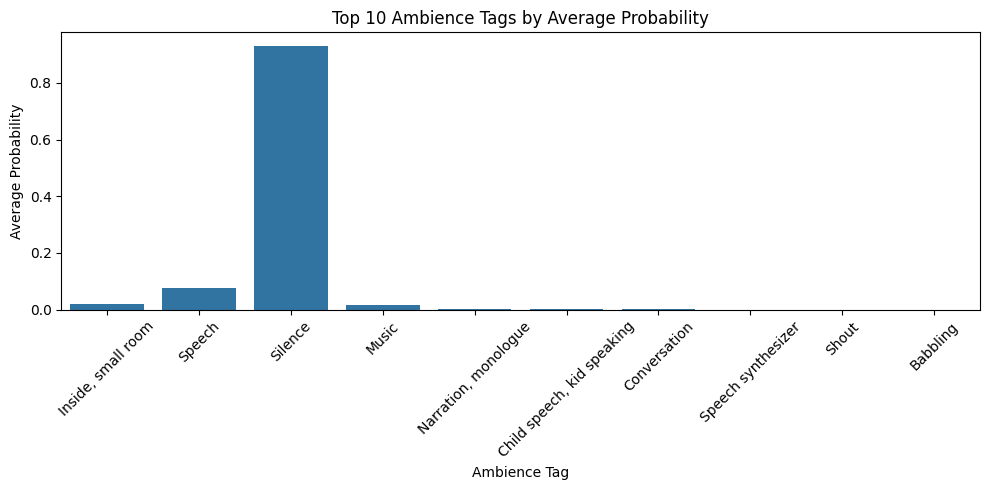

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x='Tag', y='Avg_Prob', data=tag_df.head(10))
plt.title("Top 10 Ambience Tags by Average Probability")
plt.xticks(rotation=45)
plt.ylabel("Average Probability")
plt.xlabel("Ambience Tag")
plt.tight_layout()
plt.show()

### Ambience

전체 약 47만 건의 `m_ambience` 데이터를 분석한 결과, 가장 빈도가 높은 태그는 `Inside, small room`, `Speech`, `Silence` 등으로 나타났다.


특히 `Silence`는 평균 확률이 0.93으로 매우 높게 나타나, 대부분의 시간 동안 조용한 환경이 유지되었음을 알 수 있다.

반면, `Speech`, `Music` 등의 태그는 등장 빈도는 높았으나 평균 확률은 상대적으로 낮게 나타나, 해당 태그들이 감지되었더라도 확실성이 낮았던 것으로 보인다.

이러한 결과는 사용자가 대부분의 시간 동안 실내에 있었으며, 비교적 조용한 환경에서 생활했음을 시사한다.

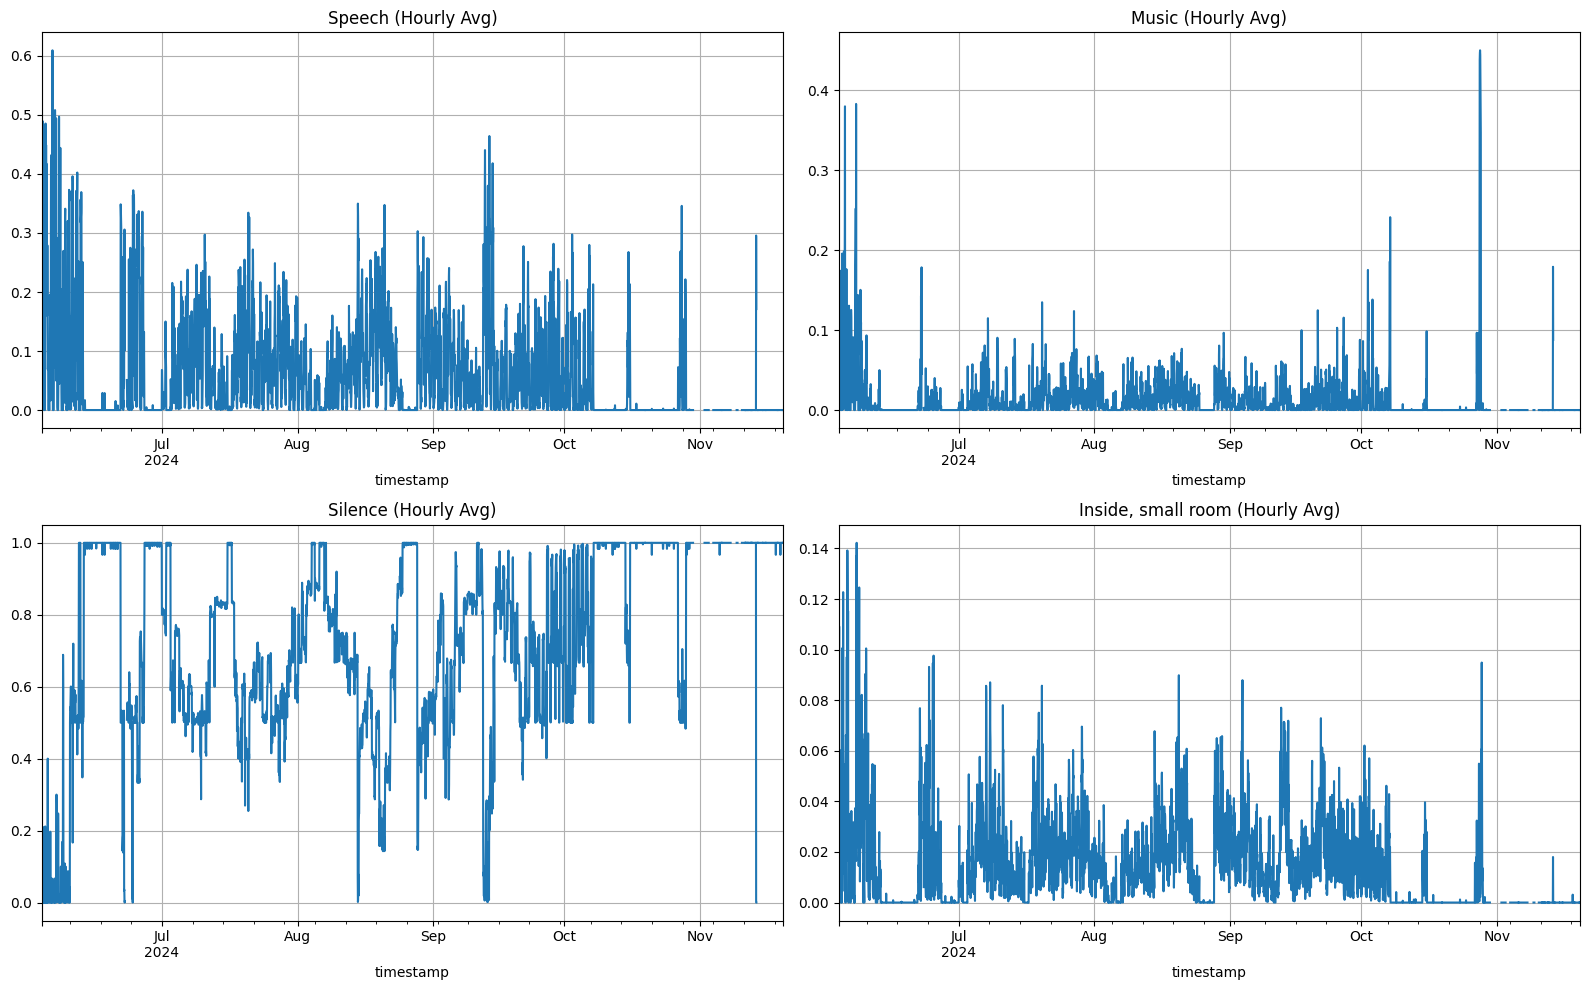

In [ ]:
# 태그 확률 추출 함수
def extract_prob(row, target):
    for item in row:
        if item[0] == target:
            return float(item[1])
    return 0.0

# 필요한 태그들 확률 컬럼 추가
df3['speech_prob'] = df3['m_ambience'].apply(lambda x: extract_prob(x, 'Speech'))
df3['music_prob'] = df3['m_ambience'].apply(lambda x: extract_prob(x, 'Music'))
df3['silence_prob'] = df3['m_ambience'].apply(lambda x: extract_prob(x, 'Silence'))
df3['room_prob'] = df3['m_ambience'].apply(lambda x: extract_prob(x, 'Inside, small room'))

# 시간 단위 리샘플링
speech_hourly = df3['speech_prob'].resample('1h').mean()
music_hourly = df3['music_prob'].resample('1h').mean()
silence_hourly = df3['silence_prob'].resample('1h').mean()
room_hourly = df3['room_prob'].resample('1h').mean()

# subplot으로 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
speech_hourly.plot()
plt.title("Speech (Hourly Avg)")
plt.grid()

plt.subplot(2, 2, 2)
music_hourly.plot()
plt.title("Music (Hourly Avg)")
plt.grid()

plt.subplot(2, 2, 3)
silence_hourly.plot()
plt.title("Silence (Hourly Avg)")
plt.grid()

plt.subplot(2, 2, 4)
room_hourly.plot()
plt.title("Inside, small room (Hourly Avg)")
plt.grid()

plt.tight_layout()
plt.show()

1. Speech (대화)
- 7~8월 중심으로 자주 등장, 이후 점차 줄어듦
- 낮 시간대나 특정 구간에서 확 튀는 모습
- 활동적인 시간대에 사람들과 접촉(대화) 있었을 가능성
- 사용자가 초중반 시점에는 활발한 사회 활동을 했고, 후반부에는 상대적으로 조용했던 환경일 가능성과 사회적 상호작용 시사

2. Music (음악)
- 대부분 시간은 0 근처, 하지만 일부 구간에서 급상승
- 집중 시간 / 운동 / 여가 시간대일 수 있음
- 특히 10월 말~11월 초 쯤 강하게 나타난다.
- 전체적으로 음악 환경은 적었지만, 특정 시간대에 의도적으로 음악을 들은 행동이 있었을 가능성

3. Silence (정적)
- 전 기간에 걸쳐 거의 대부분 시간 0.9~1.0 수준 유지
- 즉, 주변 소리가 거의 없거나 무음 상태
- 중간중간 소폭 떨어지는 구간 → Speech 또는 Music 등 감지된 순간일 것
- 대부분의 시간 동안 사용자는 조용한 환경에 있었으며, 노이즈나 활동이 적은 생활 패턴

4. Inside, small room
- 전체적으로 0.0 ~ 0.15 정도의 낮은 값 유지
- 하지만 일정 간격으로 뚜렷한 증가 구간 반복됨
- 매일 또는 주간 루틴처럼 실내 환경에서 반복적인 일상 루틴이 있었을 가능성
- 일상에서 반복적으로 실내에서 머무는 구간이 존재함.

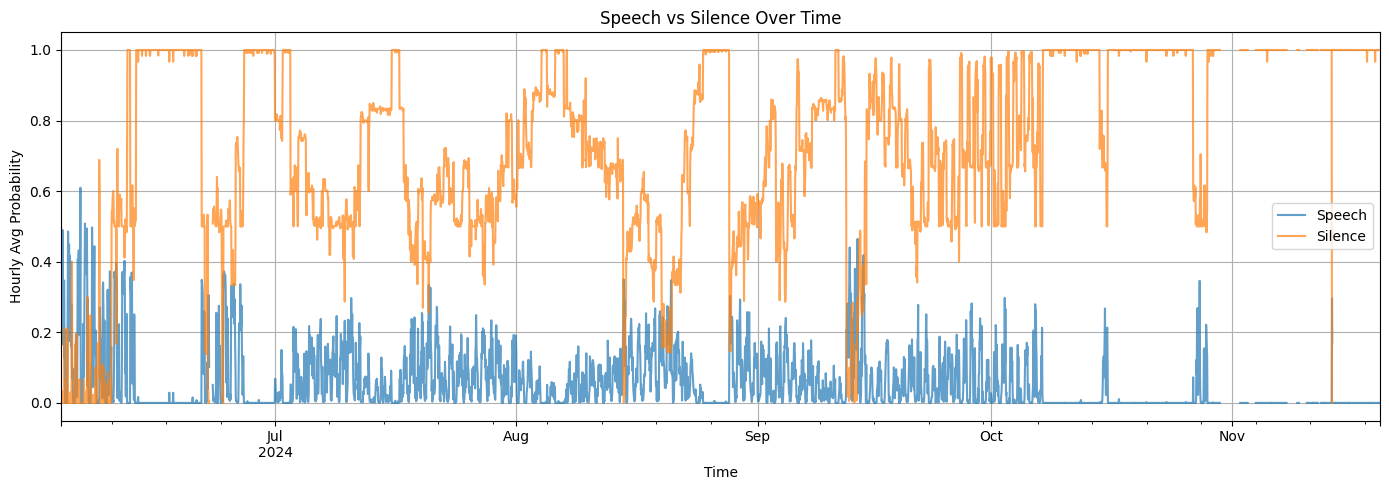

In [ ]:
plt.figure(figsize=(14, 5))
speech_hourly.plot(label='Speech', alpha=0.7)
silence_hourly.plot(label='Silence', alpha=0.7)
plt.title("Speech vs Silence Over Time")
plt.ylabel("Hourly Avg Probability")
plt.xlabel("Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

`Speech`와 `Silence` 태그의 확률을 시계열로 시각화한 결과,  
두 태그는 대부분의 시간 동안 반대되는 패턴을 보이며,  
사용자의 활동과 휴식 상태를 뚜렷하게 구분할 수 있었다.

- 6~7월 초: 말소리가 자주 감지되어 활동적인 상태였음을 시사한다.
- 7월 중순~10월: 대부분의 시간에서 `Silence`가 우세하여, 비교적 **조용한 환경**이 지속되었음을 보여준다.
- 10월 후반: `Speech`가 다시 증가하며, 일시적인 활동 구간이 존재했음을 확인할 수 있다.

In [ ]:
grouped = df3.groupby('subject_id')[['speech_prob', 'silence_prob', 'music_prob', 'room_prob']].mean()
grouped.head()

,speech_prob,silence_prob,music_prob,room_prob
subject_id,,,,
id01,0.031941,0.840761,0.004337,0.005283
id02,0.045937,0.797684,0.004654,0.011405
id03,0.029605,0.861062,0.004336,0.009383
id04,0.061949,0.724789,0.015076,0.017315
id05,0.013351,0.927945,0.006742,0.005033


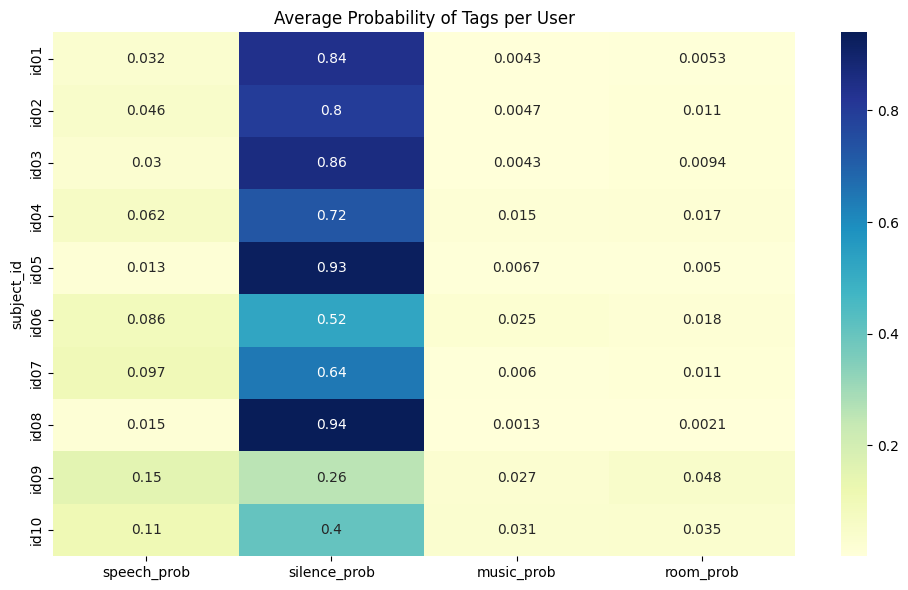

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(grouped, annot=True, cmap="YlGnBu")
plt.title("Average Probability of Tags per User")
plt.tight_layout()
plt.show()

### 사용자별 소리 태그 평균 비교

히트맵을 통해 사용자별로 `speech`, `silence`, `music`, `room` 태그의 평균 확률을 비교한 결과,  
명확한 환경/행동 패턴의 차이를 확인할 수 있었다.

- `id05`, `id08` 사용자는 `silence`가 0.9 이상으로 대부분 조용한 환경에서 시간을 보냈다.
- 반면, `id09`, `id10`은 `speech` 및 `music` 확률이 높아 상대적으로 활동적이고 외향적인 행동 패턴을 보였다.
- `room_prob(inside, small room)` 기준으로는 `id09`, `id10`이 가장 높은 값을 보여, 실내 공간에서의 활동 비중이 높았던 사용자로 추정된다.

이러한 차이는 클러스터링, 사용자 그룹화 등 다양한 행동 분석에 활용 가능하다.

* `room_prob`는 소리 환경 중 `Inside, small room` 태그의 평균 확률로,  
사용자가 실내 공간에서 활동한 비율을 간접적으로 나타낸다.  
이 값을 통해 실내 중심의 생활 패턴을 가진 사용자와 외부 활동이 많은 사용자를 비교할 수 있다.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
grouped['cluster'] = kmeans.fit_predict(grouped)

# 클러스터별 특징 확인
grouped.groupby('cluster').mean()

,speech_prob,silence_prob,music_prob,room_prob
cluster,,,,
0,0.079598,0.684057,0.010514,0.014407
1,0.116001,0.394038,0.027827,0.033698
2,0.027081,0.873468,0.004268,0.006645


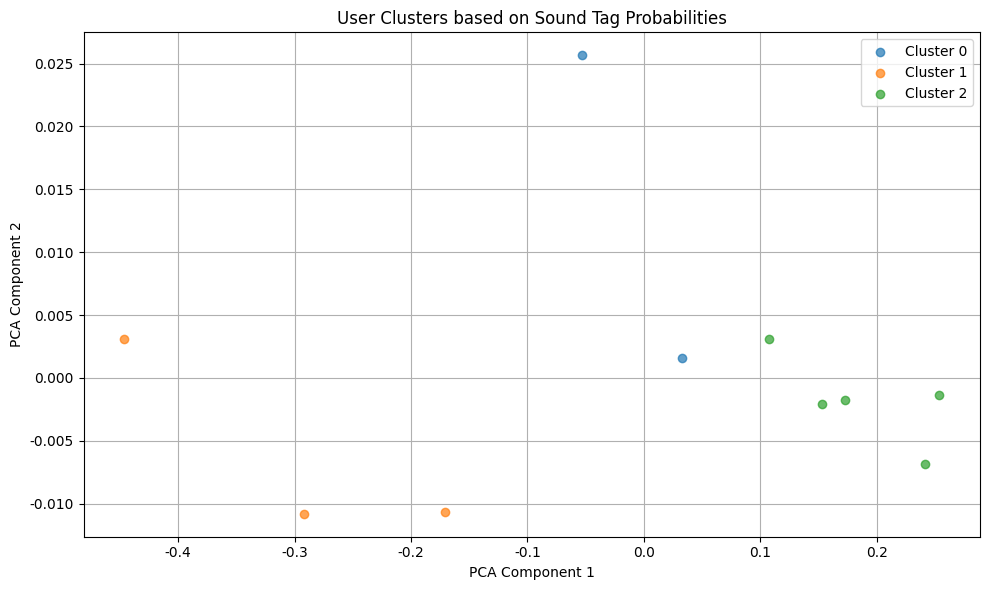

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 클러스터링 전에 데이터만 분리
X = grouped.drop('cluster', axis=1)

# PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 결과를 DataFrame으로 정리
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = grouped['cluster'].values
pca_df['subject_id'] = grouped.index

# 시각화
plt.figure(figsize=(10, 6))
for label in sorted(pca_df['cluster'].unique()):
    subset = pca_df[pca_df['cluster'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {label}', alpha=0.7)

plt.title("User Clusters based on Sound Tag Probabilities")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 사용자 클러스터링 결과 해석

- Cluster 1 (조용한 사용자 그룹)
  대부분의 시간 동안 `silence`가 높은 사용자로, 외부 활동보다는 실내 또는 정적인 환경에서 생활했을 가능성이 높다.

- Cluster 2 (활동적인 사용자 그룹)  
  `speech`, `music`, `room` 태그 확률이 비교적 높아, 외부 활동이나 사회적 활동이 많은 사용자일 가능성이 있다.

- Cluster 0 (중간 그룹)
  극단적인 특성 없이 평균적인 소리 환경을 가진 사용자들로 구성되어 있다.

이러한 분류는 개인 맞춤형 환경 분석, 행동 예측, 추천 시스템 등 다양한 응용에 활용 가능함.

### (4) mBle
: 사용자의 주변에서 감지된 블루투스 기기 목록

In [ ]:
df4 = pd.read_parquet("ch2025_mBle.parquet")
df4.info()
df4.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21830 entries, 0 to 21829
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   subject_id  21830 non-null  object        
 1   timestamp   21830 non-null  datetime64[ns]
 2   m_ble       21830 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 511.8+ KB


,subject_id,timestamp,m_ble
0,id01,2024-06-26 12:13:00,"[{'address': '00:15:7C:11:80:8D', 'device_clas..."
1,id01,2024-06-26 12:23:00,"[{'address': '0A:B1:26:4D:76:21', 'device_clas..."
2,id01,2024-06-26 12:33:00,"[{'address': '04:F5:AE:39:95:E0', 'device_clas..."
3,id01,2024-06-26 13:23:00,"[{'address': '06:C0:D2:6D:9F:69', 'device_clas..."
4,id01,2024-06-26 14:23:00,"[{'address': '10:2B:41:74:9F:B1', 'device_clas..."


In [ ]:
df4.isnull().sum()

,0
subject_id,0
m_ble,0
parsed,0
ble_count,0


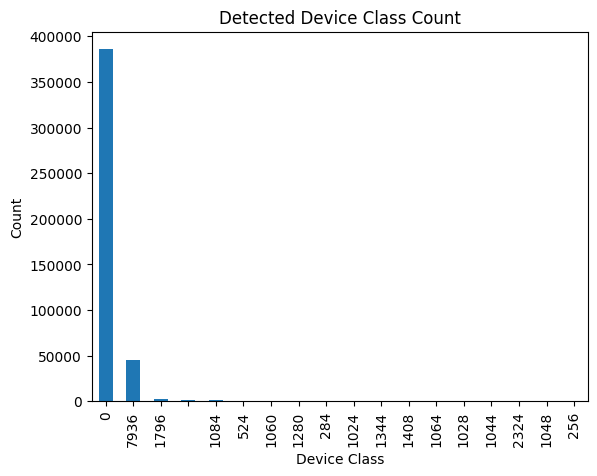

In [ ]:
from collections import Counter

device_counter = Counter()
for row in df4['m_ble']:
    for device in row:
        device_counter[device['device_class']] += 1

# 시각화
import pandas as pd
import matplotlib.pyplot as plt

pd.Series(device_counter).sort_values(ascending=False).plot(kind='bar')
plt.title("Detected Device Class Count")
plt.xlabel("Device Class")
plt.ylabel("Count")
plt.show()

- 대부분의 감지된 블루투스 장치는 `device_class = 0`으로 나타났으며, 이는 클래스 정보를 포함하지 않은 장치로 해석된다.
- 이는 BLE 데이터의 한계로, 장치 분류를 위해서는 RSSI나 MAC 패턴 등 추가적인 정보 활용이 필요하다.

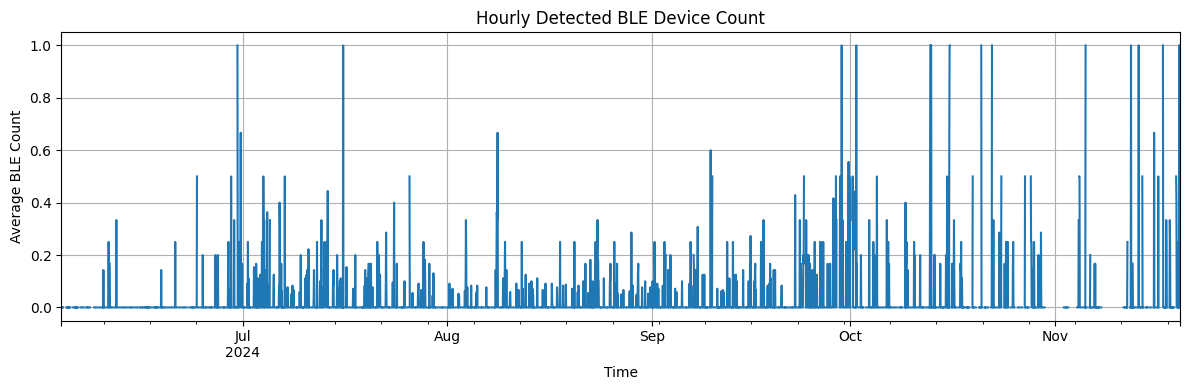

In [ ]:
import ast

def safe_parse_ble(x):
    try:
        # 문자열로 바꿔서 ast 파싱
        return ast.literal_eval(str(x).replace('array(', '').replace(')', ''))
    except:
        return []

df4['parsed'] = df4['m_ble'].apply(safe_parse_ble)
df4['ble_count'] = df4['parsed'].apply(len)

# 시간 인덱스 설정 및 리샘플링
df4.set_index('timestamp', inplace=True)
ble_hourly = df4['ble_count'].resample('1h').mean()

# 시계열 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
ble_hourly.plot()
plt.title("Hourly Detected BLE Device Count")
plt.xlabel("Time")
plt.ylabel("Average BLE Count")
plt.grid()
plt.tight_layout()
plt.show()

Bluetooth Low Energy = BLE

대부분의 시간 구간에서는 BLE 기기 탐지 빈도가 0에 수렴하며, 이는 사용자의 주변에 BLE 기기가 존재하지 않았거나 스캔이 비활성화된 상태였음을 의미한다.

반면, 일부 시간대에서는 BLE 탐지 빈도가 급격히 증가하는 구간이 관찰되었으며, 이는 사용자 주변에 다수의 BLE 기기가 존재했던 환경(예: 다중 이용 시설, 대중교통 등)에 있었음을 시사한다.

특히 10월 이후부터는 BLE 탐지 빈도의 분산이 증가하는 경향을 보이며, 이는 데이터 수집 방식의 변경 혹은 사용자의 생활 패턴 변화 가능성을 내포한다.

BLE 탐지 시계열은 사용자의 이동성, 혼잡도 환경 노출 정도, 또는 외부 활동량 추정 등에 유의미한 보조 지표로 활용될 수 있다.

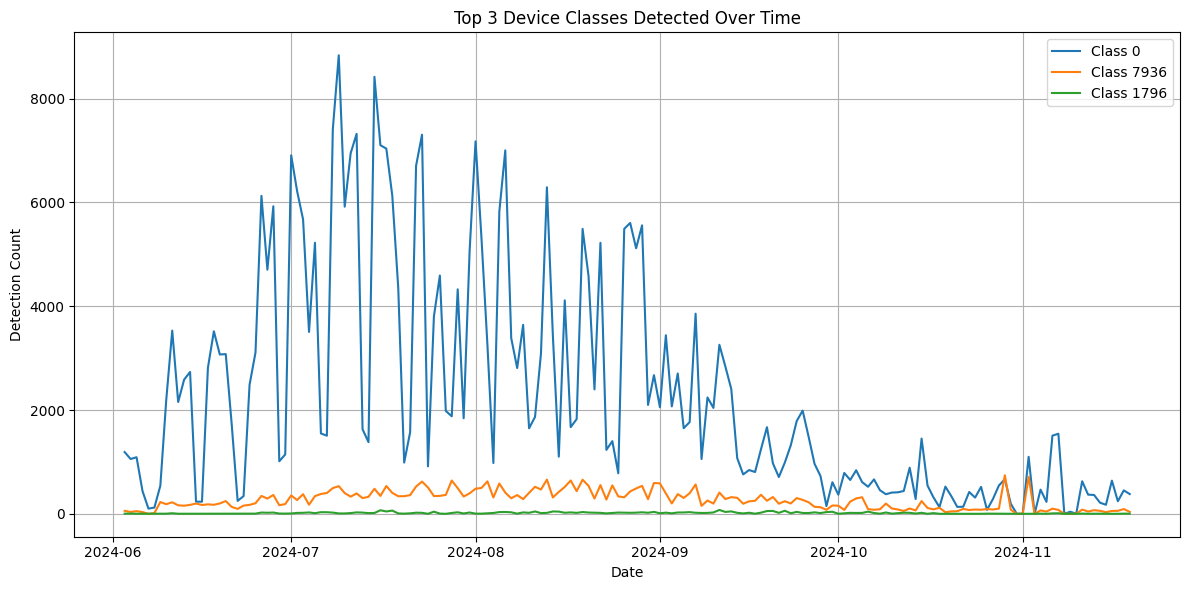

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import defaultdict

# 1. m_ble 컬럼 파싱 (리스트 형태로 변환)
df4['parsed'] = df4['m_ble'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 2. timestamp 기준 시간 인덱스로 설정
df4 = df4.set_index('timestamp')

# 3. device_class별 시간대별 개수 세기
class_time_count = defaultdict(list)

for timestamp, row in df4['parsed'].items():
    counter = defaultdict(int)
    for device in row:
        if isinstance(device, dict) and 'device_class' in device:
            cls = device['device_class']
            counter[cls] += 1
    for cls, cnt in counter.items():
        class_time_count[cls].append((timestamp, cnt))

# 4. DataFrame으로 변환
class_dfs = {}
for cls, values in class_time_count.items():
    temp_df = pd.DataFrame(values, columns=['timestamp', 'count'])
    temp_df = temp_df.set_index('timestamp').resample('1D').sum()  # 일별 집계
    class_dfs[cls] = temp_df

# 5. 상위 상위 3개 device_class 기준으로 시각화
top_classes = sorted(class_dfs.items(), key=lambda x: x[1]['count'].sum(), reverse=True)[:3]

plt.figure(figsize=(12, 6))
for cls, df_cls in top_classes:
    plt.plot(df_cls.index, df_cls['count'], label=f"Class {cls}")

plt.title("Top 3 Device Classes Detected Over Time")
plt.xlabel("Date")
plt.ylabel("Detection Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Class 0 (미정의 또는 알 수 없는 디바이스 클래스)
- 압도적으로 많은 탐지 수를 기록함.
- 특히 7월~8월 사이에 활발한 탐지 빈도를 보였으며, 이후 9월부터 급감하는 경향이 확인됨.
- 이는 해당 기간 동안 BLE 활성도가 높은 환경에 노출되었거나, 사용자 이동 패턴에 변화가 있었음을 시사함.


Class 7936 (오디오 장치, 예: 헤드셋, 이어폰 등)
- 상대적으로 안정적인 패턴을 보이며, 소폭의 변동을 동반한 일정한 탐지 빈도 유지
- 이는 사용자가 일상적으로 오디오 장치 사용을 지속해왔음을 의미할 수 있음.


Class 1796 (웨어러블 기기 또는 기타)
- 탐지 빈도가 전반적으로 낮음
- 하지만 일부 기간에서 소폭 증가 현상이 관찰되며, 이는 주변에 웨어러블 디바이스 소지 인구의 변화나 환경적 요인에 의한 일시적 노출로 해석 가능함.

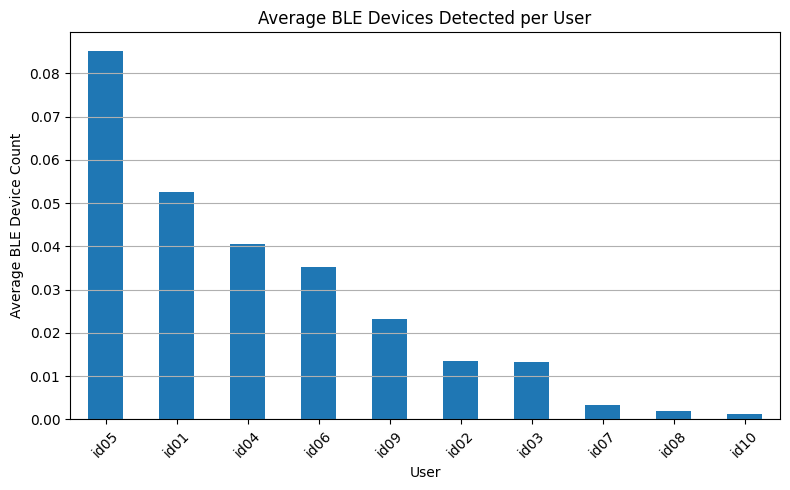

In [ ]:
# 인덱스 리셋
df4.reset_index(inplace=True)

# 사용자별 BLE 평균 개수
user_ble_mean = df4.groupby('subject_id')['ble_count'].mean().sort_values(ascending=False)

# 시각화
plt.figure(figsize=(8, 5))
user_ble_mean.plot(kind='bar')
plt.title("Average BLE Devices Detected per User")
plt.xlabel("User")
plt.ylabel("Average BLE Device Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

id05, id01, id04 사용자가 BLE 기기 탐지량이 가장 많음
- 이 사용자는 사람이 많이 있는 장소(지하철, 카페 등)에 자주 있었을 가능성 있음

id07 ~ id10은 BLE 탐지량이 매우 적음
- BLE 탐지 기능이 꺼져 있었거나, 상대적으로 혼자 있는 시간이 많았을 수도 있음
- BLE 수치가 행동 패턴을 반영할 수 있음
- BLE 탐지 수 = 주변에 사람이 많거나 활동적인 환경
- BLE 탐지 수가 낮음 = 정적 환경, 또는 기기 비활성 상태

BLE 탐지 수는 사회적 활동성이나 이동성의 간접 지표로 사용 가능. 예를 들어, 어떤 사용자가 주로 조용한 집에 있는지, 외부에서 활동을 많이 하는지를 구분하는 데 도움이 될 수 있음.

### (5) mGps
: 스마트폰에서 수집된 GPS 좌표 정보

- 측정 빈도: 최대 분당 12회까지 측정됨 (즉, 약 5초마다 한 번)

- 위도와 경도가 모두 -1로 기록된 데이터는 제외

In [ ]:
df5 = pd.read_parquet("ch2025_mGps.parquet")
df5.info()
df5.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800611 entries, 0 to 800610
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   subject_id  800611 non-null  object        
 1   timestamp   800611 non-null  datetime64[ns]
 2   m_gps       800611 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 18.3+ MB


,subject_id,timestamp,m_gps
0,id01,2024-06-26 12:03:00,"[{'altitude': 110.6, 'latitude': 0.2077385, 'l..."
1,id01,2024-06-26 12:04:00,"[{'altitude': 110.8, 'latitude': 0.2078068, 'l..."
2,id01,2024-06-26 12:05:00,"[{'altitude': 110.7, 'latitude': 0.2078214, 'l..."
3,id01,2024-06-26 12:06:00,"[{'altitude': 110.7, 'latitude': 0.2078395, 'l..."
4,id01,2024-06-26 12:07:00,"[{'altitude': 110.8, 'latitude': 0.2078478, 'l..."


In [ ]:
df5.isnull().sum()

,0
subject_id,0
timestamp,0
m_gps,0


In [ ]:
print(df5['m_gps'].iloc[0])

[{'altitude': 110.6, 'latitude': 0.2077385, 'longitude': 0.170027, 'speed': 0.0}
 {'altitude': 110.8, 'latitude': 0.2077759, 'longitude': 0.1699851, 'speed': 0.721}
 {'altitude': 110.8, 'latitude': 0.2077728, 'longitude': 0.1699834, 'speed': 0.0505}
 {'altitude': 110.7, 'latitude': 0.20779, 'longitude': 0.1699686, 'speed': 0.6587}
 {'altitude': 110.7, 'latitude': 0.2077914, 'longitude': 0.1699708, 'speed': 0.0568}
 {'altitude': 110.8, 'latitude': 0.2077972, 'longitude': 0.1699657, 'speed': 0.1768}
 {'altitude': 110.8, 'latitude': 0.2078002, 'longitude': 0.1699627, 'speed': 0.0907}
 {'altitude': 110.8, 'latitude': 0.2077985, 'longitude': 0.1699631, 'speed': 0.0337}
 {'altitude': 110.8, 'latitude': 0.207801, 'longitude': 0.1699642, 'speed': 0.0411}
 {'altitude': 110.8, 'latitude': 0.207802, 'longitude': 0.1699639, 'speed': 0.0296}
 {'altitude': 110.8, 'latitude': 0.2078011, 'longitude': 0.169963, 'speed': 0.0194}]


In [ ]:
import re
import ast

def fix_and_parse(row):
    try:
        # 문자열 변환
        s = str(row).strip()
        # 중괄호 사이에 쉼표 추가 (예: } { → }, {
        s_fixed = re.sub(r'\}\s*\{', '}, {', s)

        # 양쪽에 대괄호 추가 안 돼 있으면 붙이기
        if not s_fixed.startswith('['):
            s_fixed = '[' + s_fixed
        if not s_fixed.endswith(']'):
            s_fixed = s_fixed + ']'

        parsed = ast.literal_eval(s_fixed)

        if isinstance(parsed, list) and len(parsed) > 0:
            return parsed[0]  # 가장 첫 번째 GPS 정보만 반환
        else:
            return None
    except:
        return None

In [ ]:
df5['parsed'] = df5['m_gps'].apply(fix_and_parse)
df5['latitude'] = df5['parsed'].apply(lambda x: x.get('latitude') if x else None)
df5['longitude'] = df5['parsed'].apply(lambda x: x.get('longitude') if x else None)
df5['altitude'] = df5['parsed'].apply(lambda x: x.get('altitude') if x else None)

# 이상치 삭제
df5 = df5[~((df5['latitude'] == -1) & (df5['longitude'] == -1))].copy()

In [ ]:
df5[['subject_id', 'timestamp', 'latitude', 'longitude', 'altitude']].head()

,subject_id,timestamp,latitude,longitude,altitude
0,id01,2024-06-26 12:03:00,0.207738,0.170027,110.6
1,id01,2024-06-26 12:04:00,0.207807,0.169964,110.8
2,id01,2024-06-26 12:05:00,0.207821,0.169958,110.7
3,id01,2024-06-26 12:06:00,0.207840,0.169960,110.7
4,id01,2024-06-26 12:07:00,0.207848,0.169961,110.8


In [ ]:
import numpy as np

# Haversine 거리 계산 함수 (단위: 미터)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # 지구 반지름 (m)
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2) ** 2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

# 이동 거리 계산
df5['lat_shift'] = df5['latitude'].shift()
df5['lon_shift'] = df5['longitude'].shift()

df5['distance_m'] = df5.apply(
    lambda row: haversine(row['lat_shift'], row['lon_shift'], row['latitude'], row['longitude'])
    if pd.notnull(row['lat_shift']) else 0,
    axis=1
)

# 누적 거리도 계산
df5['cumulative_distance_m'] = df5['distance_m'].cumsum()

# 결과 확인
df5[['timestamp', 'latitude', 'longitude', 'distance_m', 'cumulative_distance_m']].head(10)

,timestamp,latitude,longitude,distance_m,cumulative_distance_m
0,2024-06-26 12:03:00,0.207738,0.170027,0.000000,0.000000
1,2024-06-26 12:04:00,0.207807,0.169964,10.316995,10.316995
2,2024-06-26 12:05:00,0.207821,0.169958,1.750992,12.067987
3,2024-06-26 12:06:00,0.207840,0.169960,2.024877,14.092864
4,2024-06-26 12:07:00,0.207848,0.169961,0.929592,15.022456
5,2024-06-26 12:08:00,0.207852,0.169963,0.503824,15.526280
6,2024-06-26 12:09:00,0.207851,0.169958,0.556082,16.082363
7,2024-06-26 12:10:00,0.207854,0.169960,0.429217,16.511580
8,2024-06-26 12:11:00,0.207854,0.169961,0.033358,16.544938
9,2024-06-26 12:12:00,0.207856,0.169964,0.372957,16.917895


In [ ]:
import folium
from folium.plugins import AntPath

# 1. id01 사용자 데이터만 추출 (결측 제거 포함)
user_df = df5[(df5['subject_id'] == 'id10') &
              df5['latitude'].notnull() &
              df5['longitude'].notnull()]

# 2. 위도, 경도 좌표 리스트 추출
locations = user_df[['latitude', 'longitude']].values.tolist()

# 3. 시작 위치 설정 (첫 번째 좌표 기준)
start_lat, start_lon = locations[0]

# 4. 지도 생성
m = folium.Map(location=[start_lat, start_lon], zoom_start=17)

# 5. 경로 추가 (파란선으로)
folium.PolyLine(locations, color='blue', weight=3).add_to(m)

# 6. 시작점 마커 (초록색)
folium.Marker(
    location=locations[0],
    popup='Start',
    icon=folium.Icon(color='green')
).add_to(m)

# 7. 종료점 마커 (빨간색)
folium.Marker(
    location=locations[-1],
    popup='End',
    icon=folium.Icon(color='red')
).add_to(m)

# 8. 지도 표시
m

위도 및 경도 정보를 활용하여 사용자별 이동 경로를 시각화한 결과, (id01~id10 확인) 대부분의 좌표가 해양 지역 등 비현실적인 위치에 분포되어 있는 것이 확인되었다.

(위도와 경도가 모두 -1로 기록된 데이터는 제외함에도 불구하고 ...)

이는 GPS 기록 수집 과정에서의 오류나 혹은 테스트 환경의 제한으로 인한 것으로 해석된다.

그럼에도 불구하고, 동일한 기준에서 **사용자별 상대적인 이동 거리(누적 이동 거리)**를 비교함으로써, 활동 반경에 기반한 행동 유형 분류는 가능할 것으로 판단된다.

예를 들어, 하루 평균 이동 거리가 높은 사용자들은 이동 중심의 활동형, 반대로 이동 거리가 거의 없는 경우는 정적인 생활 패턴을 보이는 유형으로 구분할 수 있다. 이러한 특징은 다른 센서 데이터(예: BLE, 소리, 충전 상태 등)와 결합하여 행동 특성 기반 사용자 클러스터링 및 라이프스타일 분석에 활용 가능할 듯 하다

### (6) mLight
: 스마트폰을 통해 측정된 주변의 밝기 수준이다.
10분 마다 측정


In [ ]:
df6 = pd.read_parquet("ch2025_mLight.parquet")
df6.info()
df6.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96258 entries, 0 to 96257
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   subject_id  96258 non-null  object        
 1   timestamp   96258 non-null  datetime64[ns]
 2   m_light     96258 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.2+ MB


,subject_id,timestamp,m_light
0,id01,2024-06-26 12:03:00,534.0
1,id01,2024-06-26 12:13:00,846.0
2,id01,2024-06-26 12:23:00,826.0
3,id01,2024-06-26 12:33:00,851.0
4,id01,2024-06-26 12:43:00,428.0


In [ ]:
df6.isnull().sum()

,0
subject_id,0
timestamp,0
m_light,0


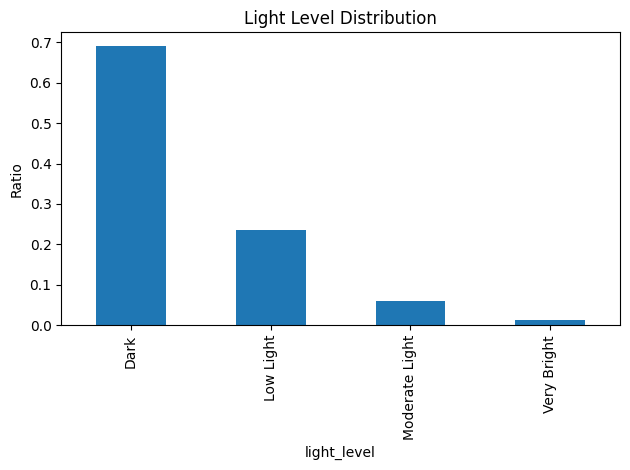

In [ ]:
# Lux Level Categorization
def categorize_lux(lux):
    if lux < 100:
        return 'Dark'
    elif lux < 500:
        return 'Low Light'
    elif lux < 1000:
        return 'Moderate Light'
    else:
        return 'Very Bright'

df6['light_level'] = df6['m_light'].apply(categorize_lux)

# Distribution of Light Levels
df6['light_level'].value_counts(normalize=True).plot(kind='bar', title="Light Level Distribution")
plt.ylabel("Ratio")
plt.tight_layout()
plt.show()

1. Dark 환경이 압도적으로 많다 (~69%)

대부분의 시간 동안 매우 어두운 환경에 있었다는 것을 의미
조명 없는 실내, 밤 시간, 또는 주로 스마트폰을 주머니/가방 안에 보관한 경우

2. Low Light (~23%)
Moderate Light (~6%)

약간의 조명이 있거나, 자연광이 들어오는 실내 환경일 가능성이 있음.
사용자들이 밝은 환경보다는 주로 조도가 낮은 환경에 있었음을 나타냄.

3. Very Bright (~1%)

야외 활동, 직사광선 하에서의 스마트폰 사용으로 추정 가능.
낮 시간대 외부 노출 시간은 굉장히 제한적이었음을 의미.

### (7) mScreenStatus
: 스마트폰 화면이 켜져 있는지의 여부
- 이진분류(0,1)


In [ ]:
df7 = pd.read_parquet("ch2025_mScreenStatus.parquet")
df7.info()
df7.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939653 entries, 0 to 939652
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   subject_id    939653 non-null  object        
 1   timestamp     939653 non-null  datetime64[ns]
 2   m_screen_use  939653 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 21.5+ MB


,subject_id,timestamp,m_screen_use
0,id01,2024-06-26 12:03:00,0
1,id01,2024-06-26 12:04:00,0
2,id01,2024-06-26 12:05:00,0
3,id01,2024-06-26 12:06:00,0
4,id01,2024-06-26 12:07:00,0


In [ ]:
df7.isnull().sum()

,0
subject_id,0
timestamp,0
m_screen_use,0


In [ ]:
df['m_screen_use'].value_counts()

,count
m_screen_use,
0,725047
1,214606


In [ ]:
df[df['m_screen_use'] == 1]['timestamp'].dt.hour.value_counts().sort_index()

,count
timestamp,
0,6775
1,6101
2,4276
3,2770
4,1470
5,1432
6,2200
7,5864
8,10378


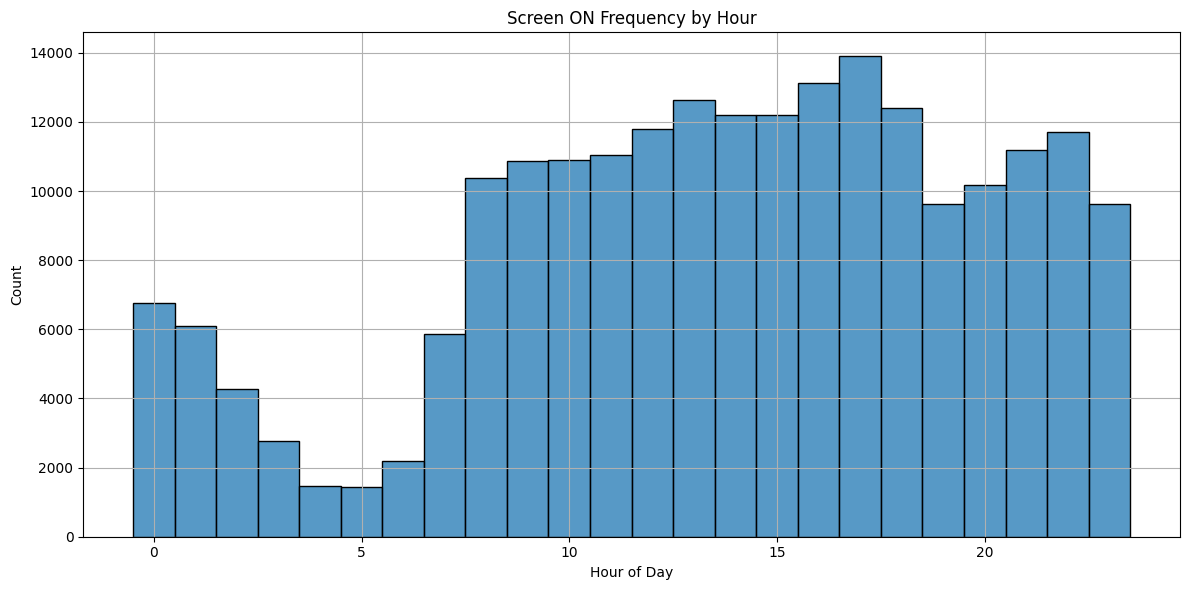

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_on = df[df['m_screen_use'] == 1].copy()
df_on['hour'] = pd.to_datetime(df_on['timestamp']).dt.hour

plt.figure(figsize=(12, 6))
sns.histplot(data=df_on, x='hour', bins=24, discrete=True, kde=False)
plt.title("Screen ON Frequency by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

1. 하루 전체적인 스마트폰 사용 리듬 확인

- 오전 7시 이후부터 화면 사용량이 빠르게 증가하며, 오전 9시~저녁 22시까지 높은 수준을 유지함.

- 정점(Peak)은 오후 17시~18시 구간으로, 가장 많은 스마트폰 사용이 이루어지는 시간대로 추정.

- 자정(0시)~새벽 5시까지는 화면 사용량이 급격히 감소 → 이 시간대는 대부분의 사용자가 수면 중일 가능성이 높음.

사용자들의 일반적인 생활 리듬(기상, 활동, 취침 시간)을 유추할 수 있음
→ 기상 시각 추정: 오전 7시~8시, 취침 시각 추정: 자정 이후 ~ 1시 전

2. 수면 패턴 간접 추정

- 사용자가 화면을 켠 시간이 m_screen_use == 1이고, 그렇지 않은 시간은 0.
- 데이터를 시간대별로 분포시키면, 수면 시간대(0시5시), 활동 시간대(7시22시)를 뚜렷하게 구분 가능

3. 개인별 분석으로 확장 가능

- 현재 분석은 전체 사용자 기반이지만, user별로 분리해서 wake-up time (첫 1 등장) sleep time (마지막 1 시간) 을 추정하면 더욱 구체적인 생활 습관을 파악할 수 있음.
- 매일 오전 8시쯤 화면을 켜고, 23시 이후 꺼진다 → 규칙적인 생활
- 새벽 2시까지도 사용 흔적이 있다 → 야행성 가능성

### (8) mUsageStats
: 어떤 앱이 얼마 동안 사용되었는지를 나타내는 스마트폰 사용 통계이다. 10분마다 측정함.

In [ ]:
df8 = pd.read_parquet("ch2025_mUsageStats.parquet")
df8.info()
df8.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45197 entries, 0 to 45196
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   subject_id     45197 non-null  object        
 1   timestamp      45197 non-null  datetime64[ns]
 2   m_usage_stats  45197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.0+ MB


,subject_id,timestamp,m_usage_stats
0,id01,2024-06-26 13:00:00,"[{'app_name': ' 캐시워크', 'total_time': 69}, {'ap..."
1,id01,2024-06-26 13:10:00,"[{'app_name': '통화', 'total_time': 26419}, {'ap..."
2,id01,2024-06-26 13:20:00,"[{'app_name': '메시지', 'total_time': 388651}, {'..."
3,id01,2024-06-26 13:30:00,"[{'app_name': '메시지', 'total_time': 211633}, {'..."
4,id01,2024-06-26 13:50:00,"[{'app_name': '카카오톡', 'total_time': 35446}, {'..."


In [ ]:
df8.isnull().sum()

,0
subject_id,0
timestamp,0
m_usage_stats,0


In [ ]:
import re
import ast
from collections import Counter
import pandas as pd

# 정제 및 파싱 함수
def clean_and_parse_usage(row):
    try:
        s = str(row).strip()
        s = s.replace('\xa0', '')  # 특수문자 제거
        s = re.sub(r'}\s*{', '}, {', s)  # 중괄호 사이에 쉼표 보정
        if not s.startswith('['):
            s = '[' + s
        if not s.endswith(']'):
            s = s + ']'
        return ast.literal_eval(s)
    except:
        return []

# 전체 앱 사용 시간 집계
app_counter = Counter()
for row in df8['m_usage_stats']:
    apps = clean_and_parse_usage(row)
    for app in apps:
        app_counter[app['app_name']] += app['total_time']

# Top 10 앱을 표로 변환
top_apps_df = pd.DataFrame(app_counter.most_common(10), columns=['App Name', 'Total Time (s)'])

# 결과 확인
print(top_apps_df)

             App Name  Total Time (s)
0            One UI 홈      4655575663
1              시스템 UI      2598865909
2                카카오톡      2408771919
3               NAVER      1156302340
4             YouTube       806269206
5             ✝️성경일독Q       778709744
6                캐시워크       555842806
7           Instagram       554532193
8                  통화       448883450
9  Microsoft Launcher       440910412


- 소셜 미디어 의존: 카카오톡, Instagram, YouTube 등의 비중이 매우 높음 → 커뮤니케이션 중심 또는 오락 중심 사용자 다수 존재

- 정보 소비 성향: NAVER 사용량이 높아 뉴스/정보 탐색형 사용자군도 관찰됨

- 신앙 기반 앱(성경일독Q)이 높은 순위에 있는 것은 흥미로운 특이점 → 일부 사용자층의 특정 신념/루틴 기반 사용 패턴

- 캐시워크, 통화 사용량이 상당히 높음 → 오프라인 활동 연계(걷기, 통화 중심)의 사용자도 존재함

- UI/런처 관련 앱들은 분석에서 제외하는 것이 더 명확한 사용자 패턴 파악에 도움이 될 수 있음 (시스템 관련 사용 포함됨)

### (9) mWifi

: 사용자의 주변에서 감지된 와이파이 기기 목록


In [ ]:
df9 = pd.read_parquet("ch2025_mWifi.parquet")
df9.info()
df9.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76336 entries, 0 to 76335
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   subject_id  76336 non-null  object        
 1   timestamp   76336 non-null  datetime64[ns]
 2   m_wifi      76336 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


,subject_id,timestamp,m_wifi
0,id01,2024-06-26 12:03:00,"[{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -78}, ..."
1,id01,2024-06-26 12:13:00,"[{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -79}, ..."
2,id01,2024-06-26 12:23:00,"[{'bssid': '10:e3:c7:0a:74:d1', 'rssi': -78}, ..."
3,id01,2024-06-26 12:33:00,"[{'bssid': '10:e3:c7:09:7f:bc', 'rssi': -80}, ..."
4,id01,2024-06-26 12:43:00,"[{'bssid': '56:46:ae:59:b1:13', 'rssi': -44}, ..."


- 'bssid': 'a0:0f:37:9a:5d:8b'
이 Wi-Fi는 집, 카페 같은 특정 장소에 설치된 고유 라우터를 의미

- 'rssi': -78
신호 강도는 약간 약한 편

- 일반적으로
40 ~ -60: 강한 신호 (가까움)
70 ~ -80: 중간 정도 거리
90 이하: 매우 약한 신호 (멀리 있거나 간섭 있음)

Wi-Fi 주변 감지 수를 기반으로 사용자의 공간 밀집도 노출 정도를 유추할 수 있음.

지속적으로 동일한 bssid가 반복되는 경우 고정된 장소에 머무름을 의미하며, 반대로 Wi-Fi 수의 급격한 변화 또는 bssid 변동은 장소 이동의 지표로 볼 수 있음.

In [ ]:
df9.isnull().sum()

,0
subject_id,0
timestamp,0
m_wifi,0


In [ ]:
import pandas as pd
import ast
import re

# Wi-Fi 데이터 불러오기
df9 = pd.read_parquet("ch2025_mWifi.parquet")

# 파싱 함수 정의
def safe_parse_wifi(row):
    try:
        s = str(row).strip()
        s = re.sub(r'}\s*{', '}, {', s)
        if not s.startswith('['):
            s = '[' + s
        if not s.endswith(']'):
            s = s + ']'
        parsed = ast.literal_eval(s)
        return parsed if isinstance(parsed, list) else []
    except:
        return []

# WiFi 개수 계산
df9['wifi_count'] = df9['m_wifi'].apply(lambda x: len(safe_parse_wifi(x)))

# 사용자별 평균 감지 WiFi 수 요약
wifi_summary = df9.groupby('subject_id')['wifi_count'].mean().reset_index()
wifi_summary.columns = ['subject_id', 'avg_wifi_count']
wifi_summary

,subject_id,avg_wifi_count
0,id01,11.513960
1,id02,17.163975
2,id03,10.912770
3,id04,13.523105
4,id05,12.687012
5,id06,23.416960
6,id07,13.745735
7,id08,13.761056
8,id09,25.693212
9,id10,18.375019


### (10) wHr
: 스마트워치로 기록된 심박수 데이터

In [ ]:
df10 = pd.read_parquet("ch2025_wHr.parquet")
df10.info()
df10.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382918 entries, 0 to 382917
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   subject_id  382918 non-null  object        
 1   timestamp   382918 non-null  datetime64[ns]
 2   heart_rate  382918 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 8.8+ MB


,subject_id,timestamp,heart_rate
0,id01,2024-06-26 12:23:00,"[134, 134, 135, 133, 134, 135, 134, 135, 134, ..."
1,id01,2024-06-26 12:24:00,"[123, 122, 121, 120, 121, 121, 120, 118, 119, ..."
2,id01,2024-06-26 12:25:00,"[120, 119, 117, 116, 119, 121, 123, 123, 121, ..."
3,id01,2024-06-26 12:26:00,"[125, 124, 124, 124, 125, 124, 124, 123, 123, ..."
4,id01,2024-06-26 12:27:00,"[116, 116, 117, 118, 116, 116, 116, 117, 115, ..."


In [ ]:
df10.isnull().sum()

,0
subject_id,0
timestamp,0
heart_rate,0


In [ ]:
# 첫 번째 행 출력
print(df10['heart_rate'].iloc[0])
print(type(df10['heart_rate'].iloc[0]))

[134 134 135 133 134 135 134 135 134 133 133 133 132 132 131 131 131 132
 132 134 134 134 132 130 128 126 126 126 127 129 130 129 130 130 127 127
 126 125 123]
<class 'numpy.ndarray'>


In [ ]:
import numpy as np

df10['hr_mean'] = df10['heart_rate'].apply(
    lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else None
)
df10['hr_min'] = df10['heart_rate'].apply(
    lambda x: float(np.min(x)) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else None
)
df10['hr_max'] = df10['heart_rate'].apply(
    lambda x: float(np.max(x)) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else None
)

In [ ]:
df10[['subject_id', 'timestamp', 'hr_mean', 'hr_min', 'hr_max']].head()

,subject_id,timestamp,hr_mean,hr_min,hr_max
0,id01,2024-06-26 12:23:00,130.794872,123.0,135.0
1,id01,2024-06-26 12:24:00,120.500000,116.0,125.0
2,id01,2024-06-26 12:25:00,119.850000,112.0,126.0
3,id01,2024-06-26 12:26:00,118.574074,114.0,125.0
4,id01,2024-06-26 12:27:00,116.260870,113.0,119.0


In [ ]:
# 사용자별 평균 심박수 계산
user_hr = df10.groupby('subject_id')['hr_mean'].mean().reset_index().rename(columns={'hr_mean': 'avg_hr'})
user_hr = user_hr.dropna()

# 상위 3명, 하위 3명 추출
top_users = user_hr.sort_values(by='avg_hr', ascending=False).head(3)
bottom_users = user_hr.sort_values(by='avg_hr', ascending=True).head(3)

print("심박수 높은 사용자 (Top 3):")
print(top_users)

print("심박수 낮은 사용자 (Bottom 3):")
print(bottom_users)

심박수 높은 사용자 (Top 3):
  subject_id     avg_hr
4       id05  96.642521
9       id10  93.580242
7       id08  93.565272
심박수 낮은 사용자 (Bottom 3):
  subject_id     avg_hr
8       id09  80.883466
0       id01  81.809996
1       id02  84.263519


- 상위 심박 유저:	활동량 많음, 운동 중일 가능성, 혹은 스트레스가 많음

- 하위 심박 유저:	비교적 안정된 상태, 많이 움직이지 않음 (앉아있거나 수면 가능성)

In [ ]:
import pandas as pd
import numpy as np
import ast

def parse_heart_rate(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except:
        return None

df10['heart_rate'] = df10['heart_rate'].apply(parse_heart_rate)

# 통계 컬럼 계산
df10['hr_mean'] = df10['heart_rate'].apply(lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else None)
df10['hour'] = pd.to_datetime(df10['timestamp']).dt.hour

# 유저별 + 시간대별 평균 심박수 정리
hourly_hr_by_user = df10.groupby(['subject_id', 'hour'])['hr_mean'].mean().reset_index()
hourly_hr_by_user = hourly_hr_by_user.rename(columns={'hr_mean': 'avg_heart_rate'})
hourly_hr_by_user

,subject_id,hour,avg_heart_rate
0,id01,0,104.259722
1,id01,1,110.142857
2,id01,2,82.430556
3,id01,3,98.056790
4,id01,4,79.782626
...,...,...,...
235,id10,19,90.748875
236,id10,20,92.407984
237,id10,21,92.602307
238,id10,22,92.184739


### (11) wLight

: 스마트워치로 측정된 주변 밝기 수준

In [ ]:
df11 = pd.read_parquet("ch2025_wLight.parquet")
df11.info()
df11.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633741 entries, 0 to 633740
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   subject_id  633741 non-null  object        
 1   timestamp   633741 non-null  datetime64[ns]
 2   w_light     633741 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 14.5+ MB


,subject_id,timestamp,w_light
0,id01,2024-06-26 12:17:00,633.0
1,id01,2024-06-26 12:18:00,483.0
2,id01,2024-06-26 12:19:00,541.0
3,id01,2024-06-26 12:20:00,547.0
4,id01,2024-06-26 12:21:00,547.0


In [ ]:
df11.isnull().sum()

,0
subject_id,0
timestamp,0
w_light,0


In [ ]:
def categorize_lux(lux):
    if lux < 100:
        return 'Dark'
    elif lux < 500:
        return 'Low Light'
    elif lux < 1000:
        return 'Moderate Light'
    else:
        return 'Very Bright'

df11['light_level'] = df11['w_light'].apply(categorize_lux)
light_dist = df11['light_level'].value_counts(normalize=True).reset_index()
light_dist.columns = ['Light Level', 'Ratio']
light_dist

,Light Level,Ratio
0,Dark,0.710287
1,Low Light,0.226365
2,Moderate Light,0.040087
3,Very Bright,0.023260


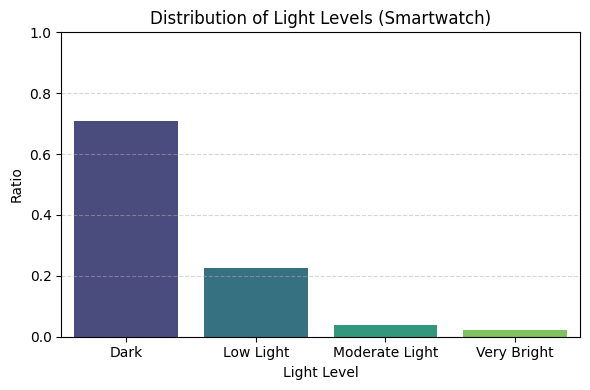

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(
    data=light_dist,
    x='Light Level',
    y='Ratio',
    hue='Light Level',
    palette='viridis',
    legend=False
)

plt.title("Distribution of Light Levels (Smartwatch)")
plt.ylabel("Ratio")
plt.xlabel("Light Level")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

생활환경의 밝기 특성 파악
일상 루틴의 간접 추정
행동 특성 분류 가능
밝기 수준 + 시간대 + 위치 정보를 조합
- 정적형 사용자: 거의 어두운 환경만 있음 (집 중심)

- 활동형 사용자: 하루 내내 다양한 밝기 수준 노출 (이동, 야외 활동 등)

- 야행성 사용자: 저녁~새벽 구간에서만 밝기 수치 변화


In [ ]:
df11['hour'] = df11['timestamp'].dt.hour
avg_brightness_by_hour = df11.groupby('hour')['w_light'].mean().reset_index().rename(columns={'w_light': 'avg_w_light'})
avg_brightness_by_hour

,hour,avg_w_light
0,0,20.929715
1,1,14.487610
2,2,8.661406
3,3,3.291850
4,4,1.709073
5,5,3.024969
6,6,14.846351
7,7,119.403248
8,8,484.341845
9,9,307.011238


스마트워치(w_Light) 센서를 통해 측정된 시간대별 평균 밝기 수준

이걸 통해 사용자들의 생활 패턴이나 활동 시간대, 혹은 주변 환경에 대한 여러 시사점을 도출 할 수 있을 것 같습니다.

In [ ]:
avg_brightness_by_user = df11.groupby('subject_id')['w_light'].mean().reset_index().rename(columns={'w_light': 'avg_w_light'})
avg_brightness_by_user.sort_values(by='avg_w_light', ascending=False)

,subject_id,avg_w_light
6,id07,276.825760
4,id05,272.155462
7,id08,243.980014
0,id01,234.991219
3,id04,192.186153
8,id09,168.595102
5,id06,166.387569
1,id02,157.257204
2,id03,153.730301
9,id10,152.412862


사용자 생활 환경 추정

- 평균 밝기가 높을수록 → 외출 or 햇빛 많은 환경 노출 가능성
- 평균 밝기가 낮을수록 → 주로 실내 생활, 또는 조도 낮은 공간 중심

2. 행동 유형 분류 가능

활동형 사용자? 정적 생활형 (집순이, 재택 중심)?

3. 건강/수면 분석 보조 변수로 활용

- 낮에 밝은 환경 노출 많음 → 생체리듬 안정, 수면 건강에 긍정적
- 항상 어두운 환경 → 우울감, 수면 장애 등 리스크 있는 환경일 가능성

4. 다른 센서와 융합 가능

- m_activity, screen_on, m_light 등과 결합해서 통찰을 얻을 수 있음

- 낮 시간 활동 없음 + 밝기 낮음 → 수면 구간 추정
- 밝기 낮은 환경 + screen_on 많음 → 야간 사용 루틴?

### (12) wPedo

: 스마트워치로 기록된 걸음 수 데이터


In [ ]:
df12 = pd.read_parquet("ch2025_wPedo.parquet")
df12.head()

,subject_id,timestamp,step,step_frequency,running_step,walking_step,distance,speed,burned_calories
0,id01,2024-06-26 12:09:00,10,0.166667,0,0,8.33,0.138833,0.0
1,id01,2024-06-26 12:10:00,0,0.000000,0,0,0.00,0.000000,0.0
2,id01,2024-06-26 12:11:00,0,0.000000,0,0,0.00,0.000000,0.0
3,id01,2024-06-26 12:12:00,0,0.000000,0,0,0.00,0.000000,0.0
4,id01,2024-06-26 12:13:00,0,0.000000,0,0,0.00,0.000000,0.0


In [ ]:
df12.isnull().sum()

,0
subject_id,0
timestamp,0
step,0
step_frequency,0
running_step,0
walking_step,0
distance,0
speed,0
burned_calories,0


In [ ]:
# 사용자별 총 거리
df12.groupby("subject_id")["distance"].sum().sort_values(ascending=False)

,distance
subject_id,
id02,317927.958254
id07,244505.507556
id03,215428.727837
id05,209501.617212
id09,203257.190705
id04,184549.034753
id01,183955.423661
id06,147074.934510
id10,139682.857710


In [ ]:
# 사용자별 총 거리
df12.groupby("subject_id")["step_frequency"].sum().sort_values(ascending=False)

,step_frequency
subject_id,
id02,6933.350000
id07,5507.250000
id03,5087.633333
id05,4533.650000
id09,4491.133333
id04,4326.983333
id01,3975.516667
id06,3235.666667
id10,3076.716667


하루, 주간, 전체 걸음 수 및 거리 합계

- distance와 step_frequency로 운동 강도 추정 가능할 듯.
- 거리 길고 빈도 높은 사람 → 활동형 / 외향적
- 걸음 적고 활동 낮은 사용자 → 정적형 / 실내 중심

In [ ]:
df12['hour'] = df12['timestamp'].dt.hour
df12.groupby('hour')['distance'].mean().reset_index()

,hour,distance
0,0,0.212943
1,1,0.085668
2,2,0.185203
3,3,0.135612
4,4,0.074681
5,5,0.233616
6,6,0.661454
7,7,1.805019
8,8,5.210083
9,9,2.511792


- timestamp → 시간 추출해서 언제 가장 많이 걷는지 확인
- 산책 시간, 출퇴근 시간 패턴 유추 가능

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('ch2025_metrics_train.csv')
df.head()  # 처음 5행 미리보기

,subject_id,sleep_date,lifelog_date,Q1,Q2,Q3,S1,S2,S3
0,id01,2024-06-27,2024-06-26,0,0,0,0,0,1
1,id01,2024-06-28,2024-06-27,0,0,0,0,1,1
2,id01,2024-06-29,2024-06-28,1,0,0,1,1,1
3,id01,2024-06-30,2024-06-29,1,0,1,2,0,0
4,id01,2024-07-01,2024-06-30,0,1,1,1,1,1


In [ ]:
import pandas as pd

df = pd.read_csv('ch2025_submission_sample.csv')
df.head()  # 처음 5행 미리보기

,subject_id,sleep_date,lifelog_date,Q1,Q2,Q3,S1,S2,S3
0,id01,2024-07-31,2024-07-30,0,0,0,0,0,0
1,id01,2024-08-01,2024-07-31,0,0,0,0,0,0
2,id01,2024-08-02,2024-08-01,0,0,0,0,0,0
3,id01,2024-08-03,2024-08-02,0,0,0,0,0,0
4,id01,2024-08-04,2024-08-03,0,0,0,0,0,0


수면 질 관련 지표
- Q1: 기상 직후, 사용자가 주관적으로 평가한 전반적인 수면의 질
- Q2: 취침 직전, 사용자가 느낀 신체적 피로감
- Q3: 취침 직전, 사용자가 인지한 스트레스 수준

수면 가이드라인 준수 지표
- S1: 총 수면 시간이 수면 가이드라인을 충족했는지 여부
- S2: 수면 효율이 수면 가이드라인 기준을 만족하는지 여부
- S3: 수면 잠들기 지연 시간(SOL; Sleep Onset Latency)이 가이드라인을 준수하는지 여부